### Homework 2 - Question 1 - Luke Arend

In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from mt2files.trichromacy import human_color_matcher as hmc
from mt2files.trichromacy import alt_human_color_matcher as hmc2

human_color_matcher = lambda x, P: np.squeeze(hmc(x, P))
alt_human_color_matcher = lambda x, P: np.squeeze(hmc2(x, P))

rng = np.random.default_rng()

obj = scipy.io.loadmat('mt2files/colMatch.mat')
primaries = obj['P']
wavelengths = np.linspace(400, 700, 31, dtype='int')

### a)

Produce a random testlight and plot it.

In [2]:
testlight = rng.random(31)

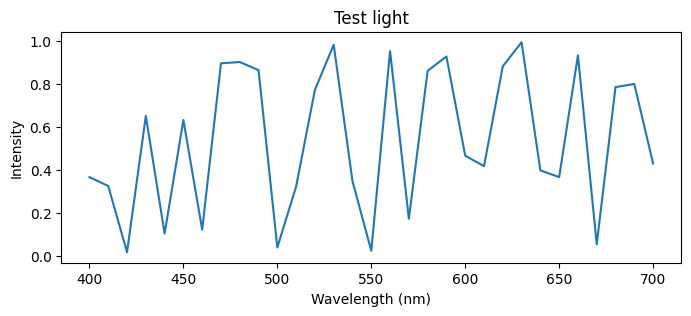

In [3]:
plt.subplots(figsize=(8, 3))
sns.lineplot(pd.Series(testlight, index=wavelengths))
plt.title('Test light')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

Run an experiment with this testlight, having a human produce knob settings.

In [4]:
knob_settings = human_color_matcher(testlight, primaries)
knob_settings

array([0.81426568, 0.37252843, 0.41917979])

Combining the primaries using these knob setting, making a new light mixture. It is a metamer of the random testlight.

In [5]:
metamer = primaries @ knob_settings

Plot the spectra of the random testlight and metamer together.

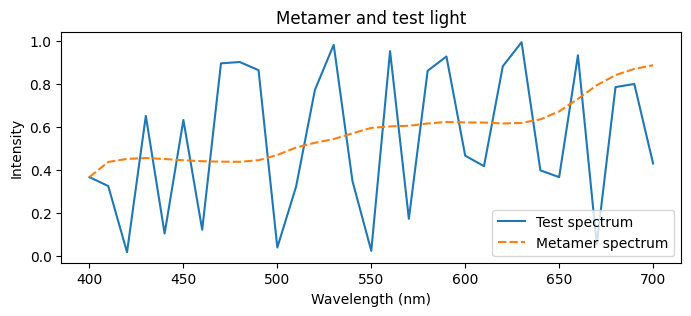

In [6]:
plt.subplots(figsize=(8, 3))
sns.lineplot(pd.DataFrame(
    {
        'Test spectrum': testlight,
        'Metamer spectrum': metamer
    },
    index=np.linspace(400, 700, 31)
))
plt.title('Metamer and test light')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

Though two spectra are different, they are mapped to the same response by the human visual system. This is possible because the visual system has a null space: there exist certain vectors in stimulus space to which the system's response is zero. Any vector in the null space can be added to a stimulus to create a metamer for that stimulus. The two different stimuli above look the same because their difference vector lies in the null space of the visual system.

### b)

If the system is linear, it has a transformation matrix `M` whose columns are the system's responses to the standard basis vectors:

In [7]:
basis = np.identity(31)
M = human_color_matcher(basis, primaries)
M.shape

(3, 31)

Then multiplying any stimulus by `M` should predict the knob settings `human_color_mapper` will produce. Verify that `M` predicts the human response on 5 random test lights:

In [8]:
testlights = np.random.rand(31, 5)

In [9]:
predicted_responses = M @ testlights
predicted_responses

array([[ 1.4479158 ,  0.94749064,  1.000194  ,  0.69911158,  1.21421439],
       [-0.3813556 ,  0.37734738, -0.28918319, -0.02830446,  0.20886837],
       [ 0.61507207,  0.33292647,  1.10058196,  0.61180029,  0.05377789]])

In [10]:
actual_responses = human_color_matcher(testlights, primaries)
actual_responses

array([[ 1.4479158 ,  0.94749064,  1.000194  ,  0.69911158,  1.21421439],
       [-0.3813556 ,  0.37734738, -0.28918319, -0.02830446,  0.20886837],
       [ 0.61507207,  0.33292647,  1.10058196,  0.61180029,  0.05377789]])

In [11]:
np.allclose(predicted_responses, actual_responses)

True

### c)

Here we have three different color photoreceptors. We can plot their spectral sensitivies:

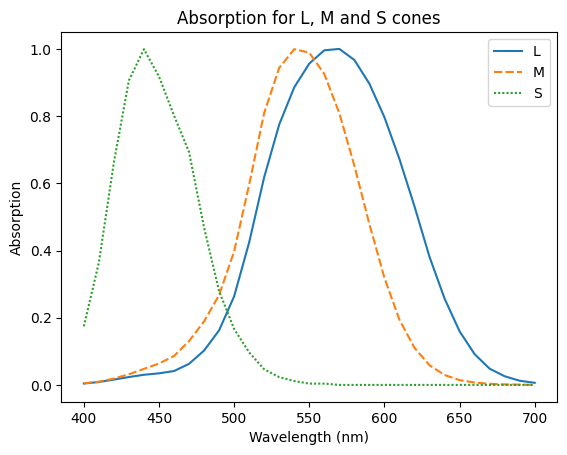

In [12]:
cones = obj['Cones']
cones_df = pd.DataFrame({
    'L': cones[0, :],
    'M': cones[1, :],
    'S': cones[2, :]
}, index=np.linspace(400, 700, 31))
sns.lineplot(cones_df)
plt.title('Absorption for L, M and S cones')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption')
plt.show()

Verify that the cone responses are equal for two stimuli that are perceptually matched.

In [13]:
stimulus1 = np.random.rand(31)
stimulus2 = primaries @ human_color_matcher(stimulus1, primaries)

In [14]:
response1 = cones @ stimulus1
response1

array([4.80600497, 4.46938486, 3.37787137])

In [15]:
response2 = cones @ stimulus2
response2

array([4.80600497, 4.46938486, 3.37787137])

In [16]:
np.allclose(response1, response2)

True

We can verify more rigorously that the cone responses are equal for any two metamers. Recall from **a)** that the difference between any two metamers is a stimulus in the null space of the human visual system. If the two metamer stimuli produce identical cone responses, then their difference vector is in the null space for the cones as well. Thus the cone response are equal for any two metamers if `M` and `cones` have the same null space.

We can inspect the singular value decomposition of each to see whether their null space is the same. Note that if $X$ has the singular value decomposition $X = USV^T$, the null space of X is spanned by the columns of $V$ which get scaled by 0 when multiplied by the $S$ matrix.

In [17]:
U, s, Vt = np.linalg.svd(M)
U.shape, Vt.shape, s

((3, 3), (31, 31), array([1.63144248, 0.86474169, 0.33562028]))

In the SVD of `M`, $V$ has 31 columns and loses 28 of them when multiplied by the $S$ matrix. The columns of $V$ are orthogonal. So the null space of `M` is just $\mathbb{R}^{28}$.

In [18]:
U, s, Vt = np.linalg.svd(cones)
U.shape, Vt.shape, s

((3, 3), (31, 31), array([3.78426349, 2.16448187, 0.7554711 ]))

The SVD of `cones` is similar: $V$ has 31 columns and loses 28 when multiplied by $S$. So the null space of `cones` is also $\mathbb{R}^{28}$, the null space of `M`.

### 4)

In [19]:
from mt2files.trichromacy import alt_human_color_matcher

We can compare normal knob settings with the knob settings for an abnormal human observer. Let's use 5 random test lights.

In [20]:
testlights = np.random.rand(31, 5)
normal_knobs = human_color_matcher(testlights, primaries)
alt_knobs = alt_human_color_matcher(testlights, primaries)

In [21]:
normal_knobs

array([[ 0.64249296,  0.93931338,  0.68282377,  1.28231734,  1.06882855],
       [ 0.37735342,  0.18864689,  0.83040969,  0.25140807,  0.51158365],
       [ 0.1868669 ,  0.56604701, -0.06313465, -0.12207872, -0.01354095]])

In [22]:
alt_knobs

array([[ 0.3683977 ,  0.7008802 ,  0.42156781,  0.98842512,  0.83306135],
       [-2.87017559, -2.63635153, -2.26499712, -3.23067884, -2.28182787],
       [ 3.93190671,  3.82382594,  3.50647834,  3.8934525 ,  3.20781207]])

In [23]:
np.mean(alt_knobs - normal_knobs, axis=1)

array([-0.26068876, -3.08868653,  3.56186319])

On average, the abnormal observer chooses less of the first primary than a normal human, but uses very large amounts of the second and third primary (negative and positive, respectively) to compensate. We can measure the difference settings over hundreds of trials.

In [24]:
testlights = np.random.rand(31, 50)
normal_knobs = human_color_matcher(testlights, primaries)
alt_knobs = alt_human_color_matcher(testlights, primaries)
difference_settings = np.mean(alt_knobs - normal_knobs, axis=1)
difference_settings

array([-0.23189496, -2.74753248,  3.16844545])

What is the underlying cause of color deficiency in the alternate observer? We can diagnose this by asking what is so special about the difference settings above. This knob setting, applied to the primaries, produces the average stimulus which must be added to a random stimulus to correct that stimulus for the alternate observer. We can plot the average "correction" stimulus, and compare it to the normal human cone absorption pattern:

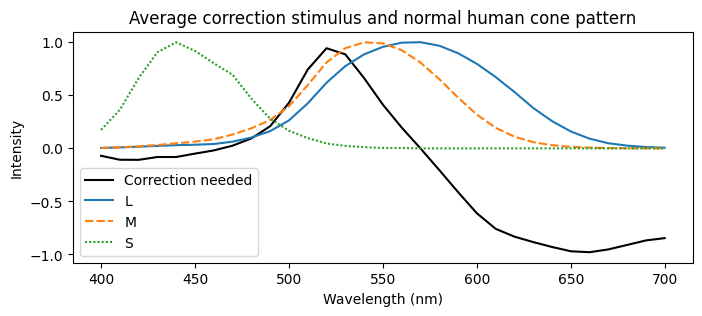

In [25]:
correction_stimulus = primaries @ difference_settings
_, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(pd.Series(correction_stimulus, index=wavelengths), ax=ax, label='Correction needed', color='k')
sns.lineplot(cones_df)
plt.title('Average correction stimulus and normal human cone pattern')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

It is apparent that the alternate observer needs a huge boost of intensity around the M cone wavelength in order to get the same amount  of M signal as a normal human observer. This suggests a deficiency in the M cone. The alternate observer must also attenuate long wavelengths. This reduces activation of the L cone, bringing its amount of activation relative to the M cone closer to that of the normal human observer. Lastly, because the M and L frequencies have both been "turned down" relative to the normal human observer, the alternate observer must reduce S frequencies slightly to compensate. A human **lacking M cones** explains the color deficiency seen above.